# One-image Sectioned FSC and Wiener filtering

Ideally for FRC/FSC analysis one would have two independent observations of the region-of-interest. Oftentimes, one only has one image to work with. Here I show hot to estimate the resolution from a single 3D image (stack), and furthermore, how to leverage the measured resolution values to do blind Wiener filtering on the same image.

In [1]:
%matplotlib inline

import os
import numpy as np
import miplib.ui.cli.miplib_entry_point_options as options
import miplib.ui.plots.image as implots
import miplib.ui.plots.frc as frcplots
from miplib.data.io import read
import miplib.processing.image as imops
import miplib.analysis.resolution.fourier_shell_correlation as fsc
from miplib.data.containers.image import Image

import urllib.request as dl



## Data

A single 3D stack of a pollen sample was acquired with a Nikon A1 confocal microscope.The image is resampled to isotropic  spacing and then padded/cropped into a cubic shape, in order to make it compatible witht the SFSC calculation. The image can be downloaded from [Figshare](https://doi.org/10.6084/m9.figshare.8159165.v1).

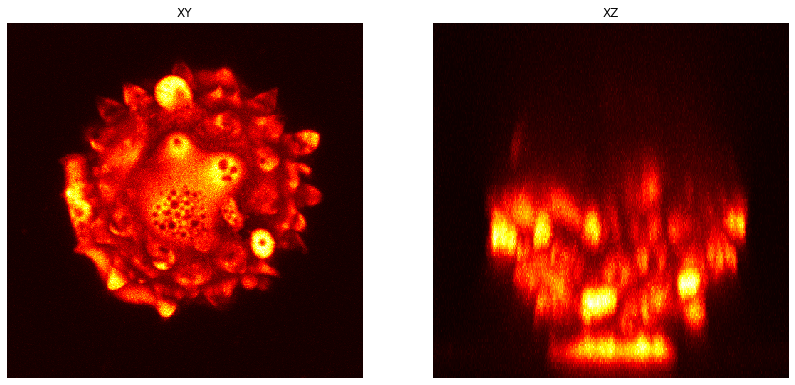

In [2]:
# Load image. It is assume that the image file is in the same directory with
# the notebook.
data_dir = os.getcwd()
image_name = "40x_TAGoff_z_galvo.nd2"
full_path = os.path.join(data_dir, image_name)

# Automatically dowload the file from figshare, if necessary.
if not os.path.exists(full_path):
        dl.urlretrieve("https://ndownloader.figshare.com/files/15203144", full_path)

image = read.get_image(full_path, channel=0)

# The FSC z-correction is based on the difference of the sampling density in XY versus Z.
z_correction = image.spacing[0]/image.spacing[1]

# Pre-process the image for FSC
# 1. Zoom to isotropic spacing, 2. zero-pad to a cube and 3. crop some useless black borders
image = imops.zoom_to_isotropic_spacing(image, order=0)
image = imops.zero_pad_to_cube(image)
image = imops.remove_zero_padding(image, ([500,]*3))

implots.display_2d_images(imops.maximum_projection(image, axis=0),
                          imops.maximum_projection(image, axis=1), 
                          image1_title='XY', image2_title='XZ')


## Sectioned FSC

Here I setup and run the SFSC analysis on the image shown above. The Fourier sphere is divided into 24 wedges (sections), with 15 degrees angular increments. 

In [3]:
# Get script options
args_list = [None, '--bin-delta=10', '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.5',
            '--angle-delta=15', '--enable-hollow-iterator', '--extract-angle-delta=.1', 
             '--resolution-point-sigma=0.01', '--frc-curve-fit-type=spline']
args = options.get_frc_script_options(args_list)

print (args)

Namespace(carma_det_idx=0, carma_gate_idx=0, channel=0, d_angle=15, d_bin=10, d_extract_angle=0.1, debug=False, directory=None, disable_hamming=False, evaluate_results=False, frc_curve_fit_degree=8, frc_curve_fit_type='spline', frc_mode='one-image', hollow_iterator=True, jupyter=False, min_filter=False, pathout=None, plot_size=(2.5, 2.5), resol_square=False, resolution_point_sigma=0.01, resolution_snr_value=0.5, resolution_threshold_criterion='snr', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.14285714285714285, save_plots=False, scale=100, show_image=False, show_plots=False, temp_dir=None, test_drive=False, verbose=False, working_directory='/home/sami/Data')


In [4]:
%%capture

result = fsc.calculate_one_image_sectioned_fsc(image, args, z_correction=z_correction)

## Results

The SFSC results are shown in a polar plot. The plot describes the calculated resolution values at different rotation angles, with respect to the XY plane. The XY plane is at 0$^\circ$-180$^\circ$  axis, and the XZ plane at the 90$^\circ$-270$^\circ$ axis. The resolution is given in micrometers.

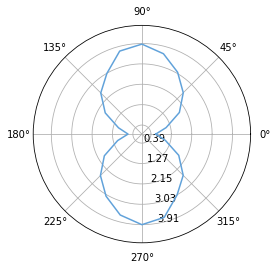

In [5]:
plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()

## Blind Wiener filtering

Here I first use the measurements above to generate a PSF, which is then used in a regular Wiener filter.

In [6]:
import miplib.psf.psfgen as psfgen

fwhm = [result[90].resolution["resolution"], result[0].resolution["resolution"]]

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.volume()

print (r"A 3D PSF was generated with FWHM (Z: {} um, XY: {} um)".format(*fwhm))

A 3D PSF was generated with FWHM (Z: 3.8875587137876315 um, XY: 0.5986743538754852 um)


In [7]:
from miplib.processing.deconvolution import wiener

# Load the image again from the disk (to get a bit smaller image to work with). 
image = read.get_image(os.path.join(data_dir, image_name), channel=0)

deconvolved = wiener.wiener_deconvolution(image, psf, snr=200, add_pad=100)


/Users/sami/miniconda3/envs/miplib/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


## Results

The images before and after the Wiener filtering (deconvolution) are compared.

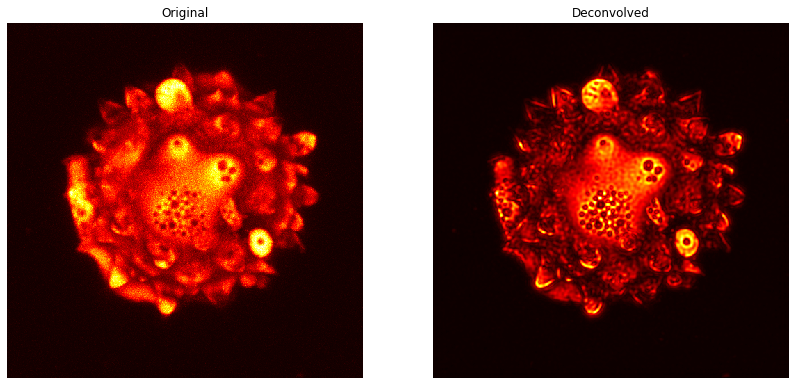

In [8]:

implots.display_2d_images(imops.maximum_projection(image, axis=0),
                          imops.maximum_projection(deconvolved, axis=0), 
                          image1_title='Original', image2_title='Deconvolved')